# NFL Big Data Bowl 2022

**Authors**: Chaya Norton, Elizabeth Campolongo, Ranthony Edmonds, Kenneth Howe

In this notebook, we make use of topologically derived machine learning algorithms to perform a clustering analysis of high-resolution tracking data for two NFL Special Teams play types, namely field goals and extra points. The aim is to determine if the plays exhibit any intrinsic separation in the data that can be used to classify meaningful differences between plays (e.g. distinct strategies or outcomes).

## I. Getting the Initial Data

In [1]:
import pandas as pd

### 1. Importing the NFL Big Data Bowl Datasets

To start, we'll need data concerning the plays, games, and players.

In [2]:
plays = pd.read_csv('~/Documents/coding/NFL_Data/plays.csv')
games = pd.read_csv('~/Documents/coding/NFL_Data/games.csv')
players = pd.read_csv('~/Documents/coding/NFL_Data/players.csv')

To reduce the amount of memory occupied by the very large tracking dataset, we have separated the tracking data according to each play type.

In [3]:
fg_tracking_2018 = pd.read_csv('~/Documents/coding/NFL_Data/tracking_fg18.csv')
fg_tracking_2019 = pd.read_csv('~/Documents/coding/NFL_Data/tracking_fg19.csv')
fg_tracking_2020 = pd.read_csv('~/Documents/coding/NFL_Data/tracking_fg20.csv')

In [4]:
ep_tracking_2018 = pd.read_csv('~/Documents/coding/NFL_Data/tracking_ep18.csv')
ep_tracking_2019 = pd.read_csv('~/Documents/coding/NFL_Data/tracking_ep19.csv')
ep_tracking_2020 = pd.read_csv('~/Documents/coding/NFL_Data/tracking_ep20.csv')

## II. Performing Initial Cleaning/Pre-Processing

To perform our analyses of field goal and extra point plays, we will need to prepare datasets containing the data regarding each play type. Before we assemble these datasets, it will be useful to perform some initial cleaning and pre-processing on the raw data that we just imported.

### 1. Pre-Processing Tracking Data

For the tracking data, we subdivide each of the tracking datasets into play-type specific DataFrames to reduce the scope of the larger DataFrames. We then isolate the tracking information relating only to the football across all three years and return it in its own DataFrame, dropping columns with information not available for the football itself (e.g. direction and angle).

In [5]:
from pipeline.preprocessing import preprocess_tracking, preprocess_football_track

In [6]:
# Pre-process field goal data
fg_tracking_2018, fg_tracking_2019, fg_tracking_2020 = preprocess_tracking(fg_tracking_2018, fg_tracking_2019, fg_tracking_2020, plays, 'Field Goal')
fg_tracking_ball = preprocess_football_track(fg_tracking_2018, fg_tracking_2019, fg_tracking_2020)

# Pre-process extra point data
ep_tracking_2018, ep_tracking_2019, ep_tracking_2020 = preprocess_tracking(ep_tracking_2018, ep_tracking_2019, ep_tracking_2020, plays, 'Extra Point')
ep_tracking_ball = preprocess_football_track(ep_tracking_2018, ep_tracking_2019, ep_tracking_2020)


### 2. Pre-Processing Play Data

For the play, we replace the game clock measurement with total elapsed game time measured in seconds and fill null values in the `penaltyYards` and `penaltyCodes` columns with "0" and "no penalty", respectively.

In [7]:
from pipeline.preprocessing import preprocess_play
from pipeline.preprocessing import drop_by_index_difference

In [8]:
play_df = preprocess_play(plays)

To eliminate plays with low-quality tracking data, we employ the following pre-processing function. In short, the function compares the labelled occasion of the given event with the moment that the event "actually" occurs (captured by the moment at which the ball reaches its maximum velocity). We discard any plays in which these two moments are substantially disparate.

### Example of Poor Quality Tracking Data:
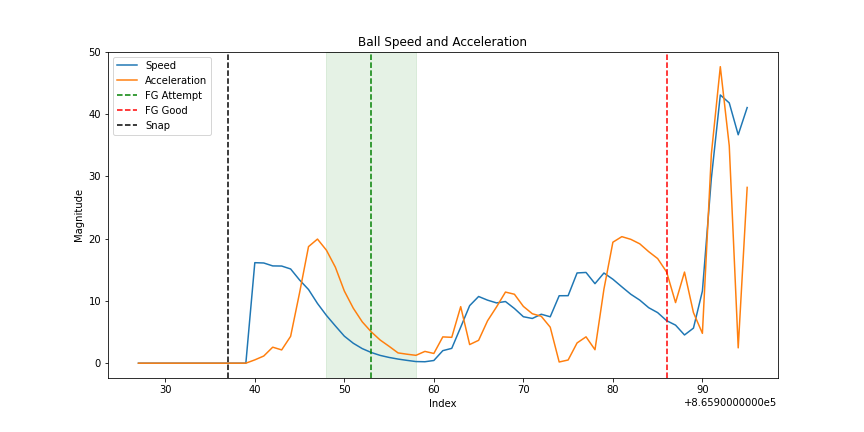

### Example of Useful Quality Tracking Data:
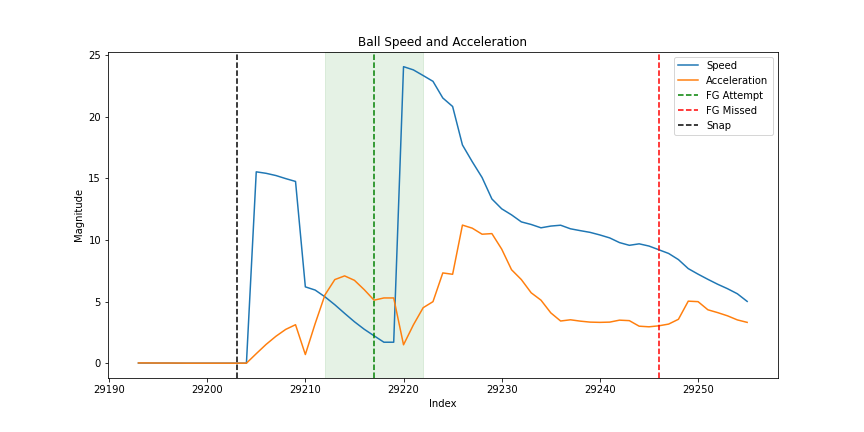

Observe that the labeling for the moment of the kick ("FG Attempt") is not accurate based on velocity of the football.
Let $\text{idx}_M$ be the index corresponding to the maximum velocity of the football during the play and let $\text{idx}_L$ be the index labeled in the tracking data as the kick attempt ("FG Attempt" in example). We define the index difference to be:
$$\text{idx}_{\text{diff}} = |\text{idx}_M - \text{idx}_L|.$$

Since poor-quality data corresponds to a larger $\text{idx}_{\text{diff}}$, this is how we will determine which data to remove. We set $\text{idx}_{\text{diff}}=7$, as that retains $90\%$ of our data while maintaining reasonable quality.


Later, we will use this green region to determine the moment of the kick by taking the index of the greatest velocity within this range.

In [9]:
fg_play_df = drop_by_index_difference(play_df, fg_tracking_ball, 'field_goal_attempt')
ep_play_df = drop_by_index_difference(play_df, ep_tracking_ball, 'extra_point_attempt')

### 3. Pre-Process Players Data

The player data requires standardization of the height measurements from foot-inch to inches.

In [10]:
from pipeline.preprocessing import preprocess_players

In [11]:
players_df = preprocess_players(players)

## III. Constructing Play Type DataFrames

As mentioned above, we want to separate our data according to play type to perform analyses on each. Here we assemble datasets containing all of the relevant data for each play type (field goals and extra points).

In [12]:
from pipeline.dataset_builders import make_field_goal, make_extra_point

In [13]:
field_goal_df = make_field_goal(fg_play_df, players_df, fg_tracking_ball)
extra_point_df = make_extra_point(ep_play_df, players_df, ep_tracking_ball)

/Users/elizabethgrace/Documents/coding/NFL-BDB-2022/pipeline/dataset_builders.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attempts_event['mergeId'] = attempts_event['gameId'].astype(str) + attempts_event['playId'].astype(str)
/Users/elizabethgrace/Documents/coding/NFL-BDB-2022/pipeline/dataset_builders.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attempts_ids['mergeId'] = attempts_ids['gameId'].astype(str) + attempts_ids['playId'].astype(str)
/Users/elizabethgrace/Documents/coding/NFL-BDB-2

Here are the lists of columns that contain given data relevant to extra points and field goals.

In [19]:
print("Field goal columns:", "\n", list(field_goal_df.columns))
print()
print("Extra point columns:", "\n", list(extra_point_df.columns))

Field goal columns: 
 ['gameId', 'playId', 'playDescription', 'quarter', 'down', 'yardsToGo', 'possessionTeam', 'specialTeamsResult', 'kickerId', 'returnerId', 'kickBlockerId', 'yardlineSide', 'yardlineNumber', 'gameClock', 'penaltyCodes', 'penaltyJerseyNumbers', 'penaltyYards', 'preSnapHomeScore', 'preSnapVisitorScore', 'passResult', 'kickLength', 'playResult', 'absoluteYardlineNumber', 'gameClockSeconds', 'kicker_height', 'kicker_weight', 'kicker_position', 'kicker_name']

Extra point columns: 
 ['gameId', 'playId', 'playDescription', 'quarter', 'possessionTeam', 'specialTeamsResult', 'kickerId', 'kickBlockerId', 'yardlineSide', 'yardlineNumber', 'gameClock', 'penaltyCodes', 'penaltyJerseyNumbers', 'penaltyYards', 'preSnapHomeScore', 'preSnapVisitorScore', 'passResult', 'absoluteYardlineNumber', 'gameClockSeconds', 'kicker_height', 'kicker_weight', 'kicker_position', 'kicker_name']


## IV. Feature Engineering

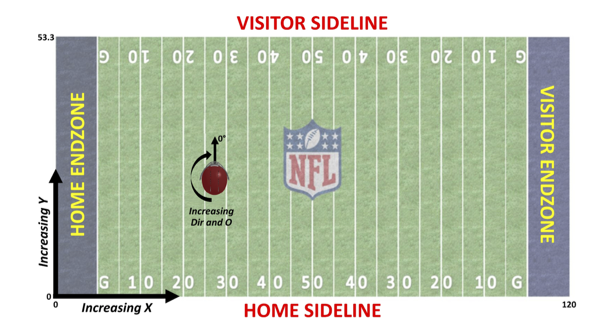

In order to improve the results of our clustering and to add meaningful insights to our analyses, we generate a handful of meaningful engineered features:

   - `endzone_y`: The location of the kicked ball at the moment in which it crosses the 0 or 120 yard line.
   - `expected_endzone_y`: The expected location of the kicked ball at the moment in which it crosses the 0 or 120 yard line, extrapolated using a straight-line trajectory from the initial moments after the kick.
   - `endzone_y_off_center`: The distance between the `endzone_y` position and the centerline of the field goal posts.
   - `endzone_y_error` - The absolute difference between `expected_endzone_y` and `endzone_y` (i.e. intended vs. actual).
   - `kicker_core_distance_1`: The distance between the kicker and the closest player on the opposing team.
   - `kicker_core_distance_3`: The distance between the kicker and the third-closest player on the opposing team. (This serves as an approximation of the density of defensive players around the kicker.)

In [20]:
from pipeline.feature_engineering import endzone_y_pos, endzone_y_expected, endzone_y_off_center, endzone_y_error, kicker_core_dist

### 1. Endzone Y-Position

Given a set $S_p$ of football tracking data for a given play $p$, let $E_{y} = \{y \in S_p: y \in (118,122)\}$.

If $|E_Y| = 2k$ for some positive integer $k$, then we set $\text{idx}_1 = k-1$ and $\text{idx}_2 = k$, else $|E_y| = 2k+1$ and we set $\text{idx}_1 = \text{idx}_2 = k-1$. Then the endzone $y$-position is
$$y_a \text{ defined as the }  y \text{ value of the football at index: } \frac{\text{idx}_1 + \text{idx}_2}{2}.$$

In [21]:
field_goal_df = endzone_y_pos(field_goal_df, fg_tracking_ball)
extra_point_df = endzone_y_pos(extra_point_df, ep_tracking_ball)

### 2. Endzone Y-Position Off-Center

Endzone $y$-position off-center $=|\frac{160}{6} - y_a|$. Since the width of the field ($y$ direction) is 160ft, and our data is measured in yards.

In [ ]:
field_goal_df = endzone_y_off_center(field_goal_df)
extra_point_df = endzone_y_off_center(extra_point_df)

### 3. Expected Endzone Y-Position

Let $x_1$ and $y_1$ be the respective $x$ and $y$ position of the football at the moment of the kick, and let $x_2$ and $y_2$ be the respective $x$ and $y$ position of the football two frames (0.2 seconds) later. Then
$$m = \frac{y_2-y_1}{x_2-x_1},$$

and we calculate the straight-line trajectory of the football so that the expected endzone $y$-position is:

$$y_e = m(120-x_1)+y_1.$$

In [22]:
field_goal_df = endzone_y_expected(field_goal_df, fg_tracking_ball, 'field_goal_attempt')
extra_point_df = endzone_y_expected(extra_point_df, ep_tracking_ball, 'extra_point_attempt')

### 4. Endzone Y-Position Error

Endzone $y$-position error $=|y_a-y_e|$.

In [ ]:
field_goal_df = endzone_y_error(field_goal_df)
extra_point_df = endzone_y_error(extra_point_df)

### 5. Kicker Core Distances

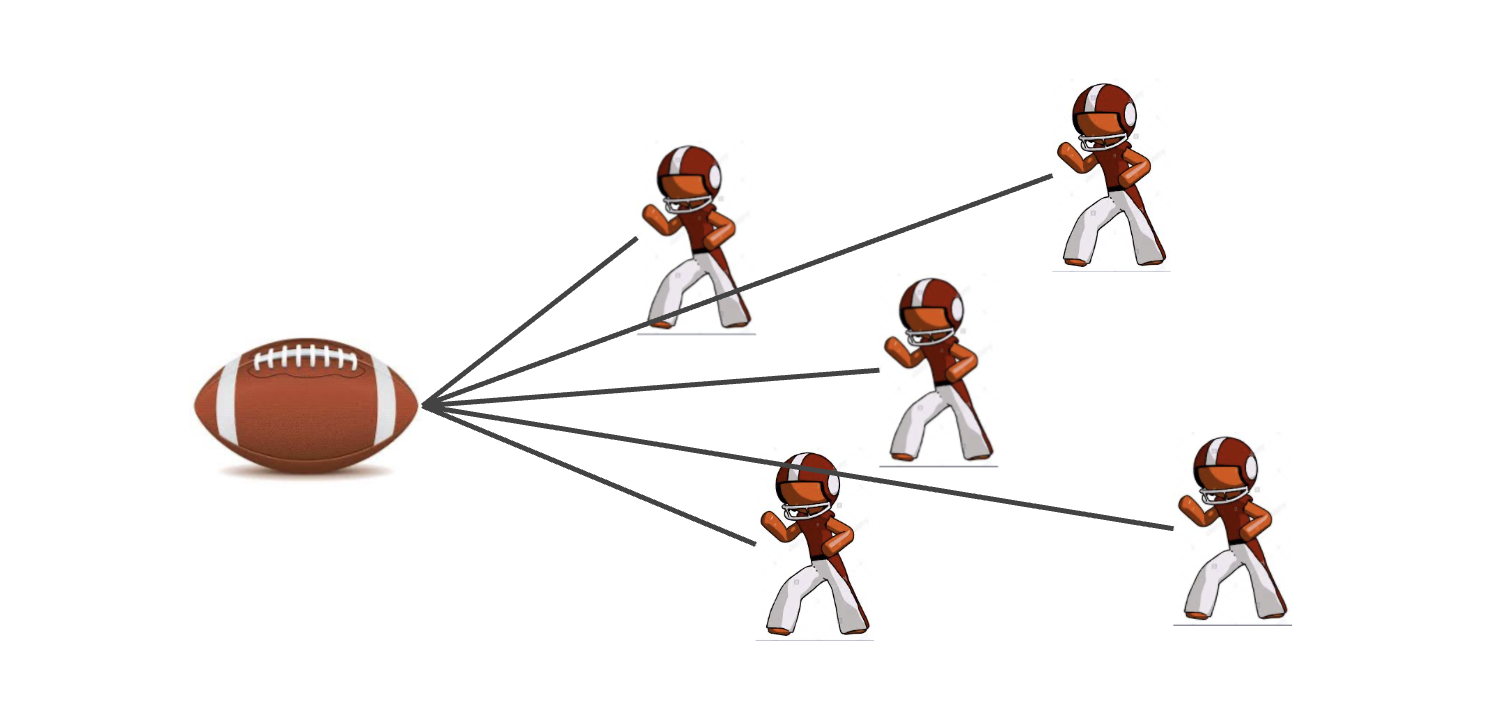

We use the $\ell_2$-norm to define distance $d$ between two points $(x_1,y_1),(x_2,y_2)$:

$$d = \sqrt{(x_2-x_1)^2 + (y_2-y_1)^2}.$$

From here we generate an ordered list, $D$, of distances of all defensive players from the kicker at the moment of the kick: 

$$D = \{d_1, d_2, \dots, d_{11}\} \text{ such that } d_1 \leq d_2 \leq \dots \leq d_{11}.$$

Then kicker core distance $k$ is $d_k$.

Thus, kicker core distance of 1 indicates the closest defensive player. We want to consider if one player breaks the offensive line.

In [ ]:
# Kicker core distance 1
field_goal_df = kicker_core_dist(field_goal_df, fg_tracking_2018, fg_tracking_2019, fg_tracking_2020, fg_tracking_ball, 'field_goal_attempt', k=1)
extra_point_df = kicker_core_dist(extra_point_df, ep_tracking_2018, ep_tracking_2019, ep_tracking_2020, ep_tracking_ball, 'extra_point_attempt', k=1)

For each `specialTeamsResult`, we analyzed the variance and standard deviation of kicker core distances 1-5, and found that 3 demonstrated the highest distinction between play results. Hence, we will use kicker core distance 3 in our clustering.

In [ ]:
# Kicker core distance 3
field_goal_df = kicker_core_dist(field_goal_df, fg_tracking_2018, fg_tracking_2019, fg_tracking_2020, fg_tracking_ball, 'field_goal_attempt', k=3)
extra_point_df = kicker_core_dist(extra_point_df, ep_tracking_2018, ep_tracking_2019, ep_tracking_2020, ep_tracking_ball, 'extra_point_attempt', k=3)

## V. Final Pre-Processing Steps

For clustering, we reduce the extra point and field goal dataframes to include only those features we wish to be considered in the clustering.

In [ ]:
from pipeline.preprocessing import preprocess_fg, preprocess_ep

In [ ]:
field_goal_X, field_goal_df = preprocess_fg(field_goal_df, encode_categorical=False)
extra_point_X, extra_point_df = preprocess_ep(extra_point_df, encode_categorical=False)

For the sake of creating a more meaningful embedding, it is important that we convert numerical features which act as categorical features to a data type that will be treated as categorical in our embedding algorithm.

For field goals, the `penaltyYards` and `down` columns act as effectively categorical features, as there are only a handful of discrete values they can take on, and the exact differences between values in these columns are not meaningful.

For extra points, the `penaltyYards` and `yardlineNumber` columns are those which act as effectively categorical.

In [ ]:
field_goal_df['penaltyYards'] = field_goal_df['penaltyYards'].astype(str)
field_goal_df['down'] = field_goal_df['down'].astype(str)

field_goal_X['penaltyYards'] = field_goal_df['penaltyYards'].astype(str)
field_goal_X['down'] = field_goal_df['down'].astype(str)

In [ ]:
extra_point_df['penaltyYards'] = extra_point_df['penaltyYards'].astype(str)
extra_point_df['yardlineNumber'] = extra_point_df['yardlineNumber'].astype(str)

extra_point_X['penaltyYards'] = extra_point_df['penaltyYards'].astype(str)
extra_point_X['yardlineNumber'] = extra_point_df['yardlineNumber'].astype(str)

## VI. Clustering with UMAP and HDBSCAN

Behind the scenes, our clustering is a process that occurs in two steps.

First, UMAP is used to embed our data into a "natural" lower-dimensional representation. To accomplish this with mixed data types, two separate embeddings are created for our numeric data and our categorical data respectively. These two embeddings are then combined to produce a final three-dimensional embedding of our data.

Once the data is embedded in this lower dimensional space, HDBSCAN is then used to detect the clusters which are intrinsically present in the data.

To accomplish both of these steps using a single, easy-to-use model, we make use of the `Amazon-DenseClus` package.

In [ ]:
from denseclus import DenseClus

### 1. Initialize the Models

In [ ]:
field_goal_clf = DenseClus(umap_combine_method='intersection_union_mapper')
extra_point_clf = DenseClus(umap_combine_method='intersection_union_mapper')

### 2. Fit the Models

In [ ]:
field_goal_clf.fit(field_goal_df)

In [ ]:
extra_point_clf.fit(extra_point_df)

### 3. Add Cluster IDs to DataFrame

In [ ]:
field_goal_df['cluster_id'] = field_goal_clf.score()
extra_point_df['cluster_id'] = extra_point_clf.score()

### 4. Create Cluster Dictionaries

In [ ]:
fg_cluster_dict = {id: field_goal_df[field_goal_df['cluster_id']==id] for id in sorted(field_goal_df['cluster_id'].unique())}
ep_cluster_dict = {id: extra_point_df[extra_point_df['cluster_id']==id] for id in sorted(extra_point_df['cluster_id'].unique())}

## VII. Investigate Model Results

In [ ]:
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import plotly.express as px

### 1. Clustering Statistics

Here we produce a quick summary of what is in each cluster. Specifically, we are interested in whether our clusters separate nicely according to `specialTeamsResult`.

In [ ]:
fg_num_clusters = field_goal_df['cluster_id'].max() + 1
ep_num_clusters = extra_point_df['cluster_id'].max() + 1

In [ ]:
fg_num_outliers = field_goal_df['cluster_id'].value_counts()[-1]
ep_num_outliers = extra_point_df['cluster_id'].value_counts()[-1]

fg_percent_outliers = 100 * fg_num_outliers / len(field_goal_df['cluster_id'])
ep_percent_outliers = 100 * ep_num_outliers / len(extra_point_df['cluster_id'])

In [ ]:
print('Field Goal Modeling Results:\n============================')
print(f'Number of Clusters: {fg_num_clusters}')
print(f'Number of Outliers: {fg_num_outliers} ({fg_percent_outliers:.2f}%)')
print(f'Special Teams Counts:\n{field_goal_df.groupby("cluster_id")["specialTeamsResult"].value_counts()}')

In [ ]:
print('Extra Point Modeling Results:\n=============================')
print(f'Number of Clusters: {ep_num_clusters}')
print(f'Number of Outliers: {ep_num_outliers} ({ep_percent_outliers:.2f}%)')
print(f'Special Teams Counts:\n{extra_point_df.groupby("cluster_id")["specialTeamsResult"].value_counts()}')

### Field Goal Stats by Cluster

In [ ]:
#[['endzone_y_error', 'endzone_y', 'kicker_core_dist_1', 'kicker_core_dist_3', 'endzone_y_off_center']].describe()

### Extra Point Stats by Cluster

In [ ]:
#[['endzone_y_error', 'endzone_y', 'kicker_core_dist_1', 'kicker_core_dist_3', 'endzone_y_off_center']].describe()

### 2. Visualize Embeddings

Since we used UMAP to embed our data, we can visualize the embedding with a 3-dimensional plot. We can also examine the results of our HDBSCAN clustering by viewing the condensed tree plots for each clustering.

In [ ]:
# Custom color sequence for clustering (helps assign outliers to grey color)
custom_color_seq = ['#777777']
custom_color_seq.extend(px.colors.qualitative.Plotly)

#### Field Goal UMAP Embedding

In [ ]:
fg_umap_embedding = field_goal_clf.mapper_.embedding_
fg_umap_df = pd.DataFrame(fg_umap_embedding, columns=['x','y','z'])
fg_umap_df['cluster_id'] = field_goal_clf.score()
fg_groups = fg_umap_df.groupby('cluster_id')

In [ ]:
fig = px.scatter_3d(
    fg_umap_df.sort_values(by='cluster_id'),
    x='x',
    y='y',
    z='z',
    color=field_goal_df['cluster_id'].sort_values().astype(str),
    color_discrete_sequence=custom_color_seq,
    title='Field Goal UMAP Embedding')
fig.update_traces(
    marker = dict(size=3)
)
fig.update_layout(
    autosize=False,
    width=900,
    height=900,
    legend_title='cluster_id'
)
fig.layout.coloraxis.colorbar.title = 'kicker_core_dist_3'
fig.show()


Explain what we see in clusters in terms of endzone $y$-position vs kicker core distance.

#### Field Goal HDBSCAN Results

In [ ]:
plt.figure(figsize=(12,12))

field_goal_clf.hdbscan_.condensed_tree_.plot(select_clusters=True, selection_palette=custom_color_seq[1:])

plt.title('HDBSCAN Condensed Tree (Field Goals)')

#plt.savefig('fg_hdbscan_tree.png')

#### Extra Point UMAP Embedding

In [ ]:
ep_umap_embedding = extra_point_clf.mapper_.embedding_
ep_umap_df = pd.DataFrame(ep_umap_embedding, columns=['x','y','z'])
ep_umap_df['cluster_id'] = extra_point_clf.score()
ep_groups = ep_umap_df.groupby('cluster_id')

In [ ]:
fig = px.scatter_3d(
    ep_umap_df.sort_values(by='cluster_id'),
    x='x',
    y='y',
    z='z',
    color=extra_point_df['cluster_id'].sort_values().astype(str),
    color_discrete_sequence=custom_color_seq,
    title='Field Goal UMAP Embedding'
)
fig.update_traces(
    marker = dict(size=3)
)
fig.update_layout(
    autosize=False,
    width=900,
    height=900,
    legend_title='cluster_id'
)


Explain what we see in clusters in terms of endzone $y$-position vs kicker core distance.

#### Extra Point HDBSCAN Results

In [ ]:
plt.figure(figsize=(12,12))

extra_point_clf.hdbscan_.condensed_tree_.plot(select_clusters=True, selection_palette=custom_color_seq[1:])

plt.title('HDBSCAN Condensed Tree (Extra Points)')

#plt.savefig('ep_hdbscan_tree.png')

### 3. Investigate Cluster Contents

Since `endzone_y` appears to be our most meaningful numerical feature, lets see how it breaks up according to our generated clusters.

In [ ]:
center = 160 / 6 # Center of field goal posts
radius = 37/12 # Halved distance between posts

plt.figure(figsize=(9,9))

plt.xlim(fg_cluster_dict[1]['endzone_y'].min(), fg_cluster_dict[2]['endzone_y'].max())

plt.hist(fg_cluster_dict[0]['endzone_y'], bins=range(54), alpha=0.7, label='Cluster 0')
plt.hist(fg_cluster_dict[1]['endzone_y'], bins=range(54), alpha=0.7, label='Cluster 1')
plt.hist(fg_cluster_dict[2]['endzone_y'], bins=range(54), alpha=0.7, label='Cluster 2')

plt.axvline(x=fg_cluster_dict[0]['endzone_y'].mean(), color='blue', linestyle='--', alpha=0.5, label='Mean 0')
plt.axvline(x=fg_cluster_dict[1]['endzone_y'].mean(), color='green', linestyle='--', alpha=0.5, label='Mean 1')
plt.axvline(x=fg_cluster_dict[2]['endzone_y'].mean(), color='red', linestyle='--', alpha=0.5, label='Mean 2')

plt.axvline(x=center-radius, color='black', label='Goal Post')
plt.axvline(x=center+radius, color='black')
plt.axvline(x=160/6, color='black', label='Goal Center', linestyle='--')

plt.title('Endzone Y-Position')
plt.xlabel('Y-Position')
plt.ylabel('Frequency')

plt.legend()

plt.savefig('fg_cluster_endzone_y.png')